In [1]:
import csv
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import statistics
import matplotlib.pyplot as plt
import networkx as nx
import collections
import operator

# 2 Differentially expressed genes

In [2]:
C = pd.read_csv(r"C:\Users\39335\Desktop\DE\DE_Project\TCGA-LUSC\TCGA-LUSC_rna_expr_data_C.txt", sep = " ")
N = pd.read_csv(r"C:\Users\39335\Desktop\DE\DE_Project\TCGA-LUSC\TCGA-LUSC_rna_expr_data_N.txt", sep = " ")

Leave only patients with both cancer and normal data, using the patient ID in the barcode (all the patients in the N database have data in the C database too)

In [3]:
for col in C:
    if not (any([(col[8:12]==c[8:12]) for c in N.columns])):
        del C[col]
C

,TCGA-77-7142-01A-11R-2045-07,TCGA-56-7823-01B-11R-2247-07,TCGA-22-5482-01A-01R-1635-07,TCGA-56-7582-01A-11R-2045-07,TCGA-56-7730-01A-11R-2125-07,TCGA-22-5471-01A-01R-1635-07,TCGA-43-6771-01A-11R-1820-07,TCGA-22-5491-01A-01R-1635-07,TCGA-85-7710-01A-11R-2125-07,TCGA-58-8386-01A-11R-2296-07,...,TCGA-92-7340-01A-21R-2045-07,TCGA-56-7731-01A-11R-2125-07,TCGA-39-5040-01A-21R-2125-07,TCGA-56-8309-01A-11R-2296-07,TCGA-22-5472-01A-01R-1635-07,TCGA-43-6773-01A-41R-1949-07,TCGA-43-7658-01A-11R-2125-07,TCGA-22-5489-01A-01R-1635-07,TCGA-56-8083-01A-11R-2247-07,TCGA-56-8082-01A-11R-2247-07
ENSG00000000003,18.020536,12.526580,7.520130,8.570585,34.546353,18.684145,4.483961,26.265688,6.525841,5.803590,...,10.962717,13.998369,3.734452,7.995145,23.158028,4.894193,16.225508,5.218992,14.892070,32.297229
ENSG00000000005,0.051976,0.017749,0.000000,0.000000,0.014922,0.039129,0.006072,0.007913,0.000000,0.000000,...,0.000000,0.020351,0.000000,0.023971,0.000000,0.015250,0.060181,0.016743,0.000000,0.025355
ENSG00000000419,26.567243,28.267701,31.099829,31.327989,35.131989,33.612966,16.904057,47.939591,46.018540,41.393558,...,37.196983,25.164337,49.400301,27.449844,30.444776,14.300066,63.921993,29.871424,31.706126,50.747991
ENSG00000000457,2.122730,1.864069,1.899460,2.419168,2.047178,2.173772,1.119243,2.339504,4.882686,1.643590,...,1.702293,1.225780,2.338103,2.242792,2.984920,1.394726,7.362284,3.062657,3.927721,2.499827
ENSG00000000460,2.412130,3.582111,1.689431,2.884558,3.351919,2.789891,1.169817,2.527843,3.104733,1.082517,...,1.785573,0.930736,2.586417,2.034096,1.458628,1.098614,7.919506,4.786459,4.751678,2.291811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281904,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004980,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.008413,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000281909,0.044101,0.000000,0.000000,0.029566,0.000000,0.020750,0.000000,0.000000,0.044058,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.021759,0.000000,0.145894,0.017758,0.000000,0.000000
ENSG00000281910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071885,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.121437,0.000000,0.101777,0.000000,0.000000,0.000000
ENSG00000281912,1.565965,0.451192,0.340983,0.892386,1.784321,1.197334,0.171515,0.894004,0.469338,0.323480,...,1.296564,0.613150,1.149711,0.383672,0.849917,0.402024,2.493132,0.796095,2.105976,1.253295


Delete the genes (rows) with at least one zero value

In [4]:
MC = C.to_records()
MN = N.to_records()
Cclean = C.to_records()
Nclean = N.to_records()

In [5]:
to_delete = set()  # Set of index to delete
for i in range(len(MC)):
    if (0 in MC[i]):
        to_delete.add(i)

for i in range(len(MN)):
    if (0 in MN[i]):
        to_delete.add(i)
        
Cclean = np.delete(Cclean, list(to_delete), axis=0)
Nclean = np.delete(Nclean, list(to_delete), axis=0)

Keep only the genes with a One-way ANOVA familywise q-value < 0.05 (calculated with Bonferroni threshold), and a fold change greater than 1.5 or below -1.5.

In [6]:
# Bonferroni threshold
def bonferroni_thresh(alpha_fwe, n):
    return alpha_fwe / n
bon_thresh = bonferroni_thresh(0.05, len(Cclean[0])) # P-value to use calculated with Bonferroni threshold that gives a familywise error < 0.05

In [7]:
genes = []  # List of the names of the differential expressed genes
idx = [] # Index to drop
# Lists for volcano plot
green = []
red = []
grey = []
yg = []
yr = []
ygrey = []

for i in range(len(Cclean)):
    p = stats.f_oneway([math.log(y,2) for y in list(Cclean[i])[1:]], [math.log(x,2) for x in list(Nclean[i])[1:]])[1]
    fc = math.log(statistics.mean(list(Cclean[i])[1:])/statistics.mean(list(Nclean[i])[1:]),2)
    if (p < bon_thresh) and (fc > 2):
        genes.append(Cclean[i][0])
        red.append(fc)
        yr.append(-math.log(p,10))
    elif (p < bon_thresh) and (fc < -2):
        genes.append(Cclean[i][0])
        green.append(fc)
        yg.append(-math.log(p,10))
    else:
        grey.append(fc)
        ygrey.append(-math.log(p,10))
        idx.append(i)

In [8]:
# Drop non differential expressed genes
Cclean = np.delete(Cclean, idx, axis=0)
Ncelan = np.delete(Nclean, idx, axis=0)

# Drop header with genes names
Cex = np.array([0 for i in range(len(Cclean[1])-1)])
Nex = np.array([0 for i in range(len(Cclean[1])-1)])
for i in range(len(Cclean)):
    Cex = np.vstack((Cex, list(Cclean[i])[1:]))
    Nex = np.vstack((Nex, list(Nclean[i])[1:]))
Cex = np.delete(Cex,0,0)
Nex = np.delete(Nex,0,0)

In [9]:
print("{} of the alayized genes are differentially expressed, they are {}% of all analyzed genes".format(len(genes),round( len(genes)/len(MC)*100 ,2)))

1695 of the alayized genes are differentially expressed, they are 2.99% of all analyzed genes


Volcano plot, in green the downed regulated genes, in red the up regulated genes

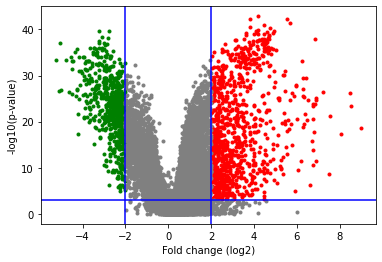

In [10]:
plt.plot(red, yr, '.', color='red')
plt.plot(green,yg,".", color="green")
plt.plot(grey,ygrey,".",color="grey")
plt.xlabel("Fold change (log2)")
plt.ylabel("-log10(p-value)")
plt.axvline(2, color='b')
plt.axvline(-2, color='b')
plt.axhline(-math.log(bon_thresh,10), color='b')
# Save plot
#plt.savefig("VolcanoPlot")

# 3 Co-expression network

In [11]:
# Apply log2 before the threshold
for i in range(len(Cclean)):
    Cex[i] = [math.log(j,2) for j in (Cex[i])]
    Nex[i] = [math.log(j,2) for j in (Nex[i])]

corr_C = np.corrcoef(Cex)
corr_N = np.corrcoef(Nex)

Set significant threshold

In [12]:
t = 0.6
for i in range(len(corr_C)):
    for j in range(len(corr_C[i])):
        if i==j:          # Set correlation with itself to 0
            corr_C[i][j] = 0
            corr_N[i][j] = 0
        else:
            if corr_C[i][j] > t:
                corr_C[i][j] = 1
            elif corr_C[i][j] < -t:
                corr_C[i][j] = -1
            else:
                corr_C[i][j] = 0
                
            if corr_N[i][j] > t:
                corr_N[i][j] = 1
            elif corr_N[i][j] < -t:
                corr_N[i][j] = -1
            else:
                corr_N[i][j] = 0

Degree distribution of C

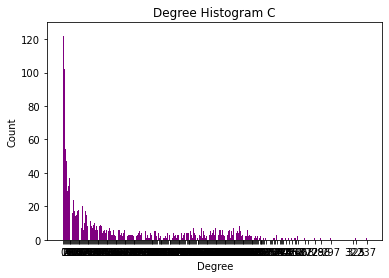

In [13]:
C = nx.from_numpy_array(corr_C)

degree_sequence = [d for n, d in C.degree()]
degreeCount = collections.Counter(sorted(degree_sequence))
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="purple")
plt.title("Degree Histogram C")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.ylim(top=130)
plt.show()

Find the hubs (5% of the nodes with the highest degree) in C

In [17]:
degreeC = dict(C.degree())  # Make degree a dictionary
indexesC = sorted(degreeC, key=degreeC.get, reverse=True) # Sort index by value to find the hubs
indexesC = indexesC[:round(len(indexesC)*0.05)]
# Find the name of hubs genes
hubsC = operator.itemgetter(*indexesC)(genes)

Do the same with N

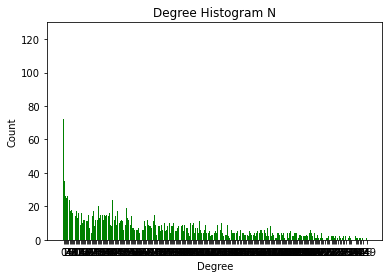

In [18]:
N = nx.from_numpy_array(corr_N)

degree_sequence = [d for n, d in N.degree()]
degreeCount = collections.Counter(sorted(degree_sequence))
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="green")
plt.title("Degree Histogram N")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.ylim(top=130)
plt.show()

In [19]:
degreeN = dict(N.degree())  # Make degree a dictionary
indexesN = sorted(degreeN, key=degreeN.get, reverse=True) # Sort index by value to find the hubs
indexesN = indexesN[:round(len(indexesN)*0.05)]
# Find the name of hubs genes
hubsN = operator.itemgetter(*indexesN)(genes)

Find the hubs in C that are not present in N

In [20]:
hubs = [item for item in hubsC if item not in hubsN]